In [6]:
from torchvision import datasets,transforms
import torch
import numpy as np

In [277]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2, fill=0),  # Padding with 2 pixels on each side with zero
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomAutocontrast(0.3),
    transforms.Normalize(.5,.5),
])


train_data = datasets.FashionMNIST("./dataset",train=True,download=True,transform=transform)
test_data = datasets.FashionMNIST("./dataset",train=False,download=True,transform=transform)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


In [279]:
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self,input_channels = 3,latent_space = 2) -> None:
        super().__init__()
        self.input_channels = input_channels
        self.latent_space = latent_space
     
        self.conv1 = nn.Conv2d(self.input_channels,32,3,2,2)
        self.batch_norm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,3,2,2)
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,3,2,2)
        self.batch_norm3 = nn.BatchNorm2d(128)

        self.flatten = nn.Flatten(1,-1)

        self.dense1 = nn.Linear(128*6*6,1024)
        self.act1 = nn.ReLU()

        self.dense2 = nn.Linear(1024,512)
        self.act2 = nn.ReLU()

        self.dense3 = nn.Linear(512,64)
        self.act3 = nn.ReLU()

        self.dense4_mu = nn.Linear(64, latent_space)
        self.dense4_logvar = nn.Linear(64, latent_space)

    def forward(self,x):
        x = self.batch_norm1(self.conv1(x))
        x = self.batch_norm2(self.conv2(x))
        x = self.batch_norm3(self.conv3(x))
    
        x = self.flatten(x)
        x = self.act1(self.dense1(x))
        x = self.act2(self.dense2(x))
        x = self.act3(self.dense3(x))
       

        return self.dense4_mu(x),self.dense4_logvar(x)


class Decoder(nn.Module):
    def __init__(self, latent_space,output_channel = 3) -> None:
        super().__init__()
        self.latent_space = latent_space
        self.output_channel = output_channel

        self.dense1 = nn.Linear(latent_space,64)
        self.act1 = nn.ReLU()

        self.dense2 = nn.Linear(64,512)
        self.act2 = nn.ReLU()

        self.dense3 = nn.Linear(512,1024)
        self.act3 = nn.ReLU()

        self.dense4 = nn.Linear(1024,128*6*6)
        self.act4 = nn.ReLU()

        self.unflat = nn.Unflatten(1, (128, 6, 6))

        self.deconv1 = nn.ConvTranspose2d(128,64,3,2,2,1)
        self.batch_norm1 = nn.BatchNorm2d(64)

        self.deconv2 = nn.ConvTranspose2d(64,32,3,2,2)
        self.batch_norm2 = nn.BatchNorm2d(32)

        self.deconv3 = nn.ConvTranspose2d(32,output_channel,3,2,2,1)
        self.batch_norm3 = nn.BatchNorm2d(output_channel)

    def forward(self,x):
        x = self.act1(self.dense1(x))
        x = self.act2(self.dense2(x))
        x = self.act3(self.dense3(x))
        x = self.act4(self.dense4(x))
        x = self.unflat(x)

        x = self.batch_norm1(self.deconv1(x))
        x = self.batch_norm2(self.deconv2(x))
        x = self.batch_norm3(self.deconv3(x))
        
        return torch.nn.functional.sigmoid(x)




In [280]:
encoder = Encoder(1,2)
decoder = Decoder(2,1)

In [281]:
sum( p.numel() for p in encoder.parameters() if p.requires_grad)+ sum( p.numel() for p in decoder.parameters() if p.requires_grad)

10745351

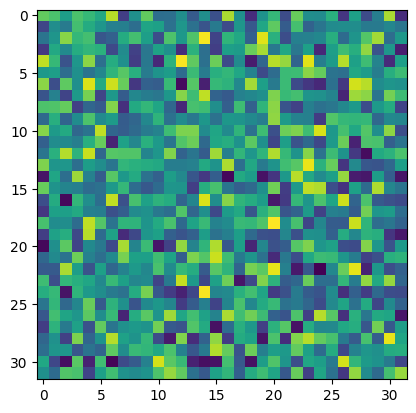

In [282]:
import matplotlib.pyplot as plt
for i,_ in train_loader:
    plt.imshow(np.array(decoder(sum(encoder(i)))[31].permute(1,2,0).detach().numpy())) 
    break

In [313]:
class VAE(nn.Module):
    def __init__(self, input_channel,latent_space) -> None:
        super().__init__()

        self.inchannel = input_channel
        self.latent_space = latent_space
        self.encoder = Encoder(self.inchannel,self.latent_space)
        self.decoder = Decoder(self.latent_space,self.inchannel)

    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self,x):
        _mean,logvar = self.encoder(x)
        x = self.reparameterize(_mean,logvar)
        recon_x = self.decoder(x)
        return recon_x, _mean,logvar

        

In [320]:
model = VAE(1,2)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [321]:
def loss_function(pred_x, x, mu, logvar):
    reconstruction_loss = torch.nn.functional.mse_loss(pred_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD

In [ ]:
for epoch in range(50):
    model.train()
    train_loss = 0
    for i,_ in train_loader:
        optimizer.zero_grad()
        pred_x,_mean,logvar= model(i)
        loss = loss_function(pred_x,i,_mean,logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

In [325]:
num_epochs = 100
i=0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, _ in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        i+=1
        if i%20==0:
            print(i,end='\r')
    
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')



Epoch 1, Loss: 841.4664504557292
Epoch 2, Loss: 786.6157173502604
Epoch 3, Loss: 768.4570770507812
Epoch 4, Loss: 759.5938965494792
Epoch 5, Loss: 754.6656234700521
Epoch 6, Loss: 750.7466010091146
Epoch 7, Loss: 749.3256632486979
Epoch 8, Loss: 748.0895660481771
Epoch 9, Loss: 746.7398958658854
Epoch 10, Loss: 746.7128765950521
Epoch 11, Loss: 746.1347431640625
Epoch 12, Loss: 746.5454399414062
Epoch 13, Loss: 745.8610566731771
Epoch 14, Loss: 745.367842578125
Epoch 15, Loss: 744.5441084309896
Epoch 16, Loss: 744.6513918945312
Epoch 17, Loss: 744.1764458658854
Epoch 18, Loss: 744.6710190755208
Epoch 19, Loss: 745.1222047851562
Epoch 20, Loss: 745.1832603190104
Epoch 21, Loss: 746.2712639973959
Epoch 22, Loss: 745.0394841796875
Epoch 23, Loss: 744.0394060872396
Epoch 24, Loss: 743.8903846679688
Epoch 25, Loss: 744.1253652018229
Epoch 26, Loss: 743.7350153645833
Epoch 27, Loss: 743.5927234700521
